In [2]:
import pandas as pd
import re
import numpy as np
import snowballstemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import preprocessor as p
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [7]:
data = pd.read_csv("tweet_Categorized_500.csv", encoding='utf-8', index_col=False)
len(data)

501

In [16]:
def categorize_label(row):
    if row['FCFR'].lower() == 'relieving':
        row['FCFR'] = 0
    else:
        row['FCFR'] = 1
    return row
data = data.apply(lambda row: categorize_label(row), axis =1)

In [17]:
data.columns

Index(['text', 'FCFR', 'filtered_tweet'], dtype='object')

In [18]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)

In [19]:
def clean_tweet(row):
    text = p.clean(row['text'])
    row['filtered_tweet'] = re.sub('\d', 'NUM', text)
    return row

In [20]:
data = data.apply(lambda row: clean_tweet(row), axis =1)

In [21]:
data = data[pd.notnull(data['filtered_tweet'])]
data = data[pd.notnull(data['FCFR'])]
len(data)

501

In [22]:
data['FCFR'].value_counts()

1    251
0    250
Name: FCFR, dtype: int64

In [23]:
data.head()


,text,FCFR,filtered_tweet
0,"If we can get through this, I imagine, the wor...",0,"If we can get through this, I imagine, the wor..."
1,next stop - The Morgue,1,next stop - The Morgue
2,"In addition to hospitals, Wuhan’s local commun...",0,"In addition to hospitals, Wuhan’s local commun..."
3,' #Coronavirus outbreak will have negative eco...,1,' #Coronavirus outbreak will have negative eco...
4,What we do know so far about corona virus outb...,0,What we do know so far about corona virus outb...


In [24]:
english_stemmer = snowballstemmer.stemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

In [25]:
tfidf_vect = StemmedTfidfVectorizer(min_df=5, stop_words='english', analyzer='word', ngram_range=(1,2), max_features=2500, norm='l2', encoding='utf-8')

In [26]:
sentence_term_tfidf = tfidf_vect.fit_transform(data['filtered_tweet'])
sentence_term_df = pd.DataFrame(sentence_term_tfidf.todense(), columns=np.sort(list(tfidf_vect.vocabulary_.keys())))
sentence_term_df.columns = sentence_term_df.columns.map(lambda x: 'W_'+'_'+x)

In [27]:
sentence_term_df.head(5)

,W__air,W__amid,W__amp,W__anim,W__antivir,W__appar,W__appreci,W__articl,W__author,W__avoid,...,W__warn,W__way,W__week,W__won,W__work,W__worker,W__world,W__wuhan,W__wuhan coronavirus,W__wuhancoronavirus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.613462,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.326707,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [28]:
sentence_term_df.shape

(501, 196)

In [29]:
labels = data['FCFR']
labels.shape

(501,)

In [30]:
features = sentence_term_df.values

In [31]:
features.shape

(501, 196)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

In [48]:
## For printing CLassification report with Accuracy
def print_classification_result(y_test, y_pred):
    target_names = ['Relieving', 'Causing']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print('Avg. Accuracy: ', accuracy_score(y_test, y_pred))

In [49]:
lg_model = LogisticRegression(random_state=0)
lg_trained = lg_model.fit(X_train,y_train)
y_pred = lg_trained.predict(X_test)
print_classification_result(y_test, y_pred)

              precision    recall  f1-score   support

   Relieving       0.59      0.63      0.61        75
     Causing       0.61      0.58      0.59        76

    accuracy                           0.60       151
   macro avg       0.60      0.60      0.60       151
weighted avg       0.60      0.60      0.60       151

Avg. Accuracy:  0.6026490066225165


In [53]:
## Intercept
lg_trained.intercept_

array([-0.05191843])

In [54]:
lg_trained.coef_

array([[ 0.6400924 ,  0.12612982, -0.00602001,  0.16873455, -0.36528916,
        -0.24176718, -0.83204749, -0.08142059, -0.00188045, -0.22872449,
        -0.18845617,  0.68943531,  0.33426139, -1.64696252,  0.1079049 ,
         0.72194476,  0.11973896,  0.49388898, -0.14230423,  0.03500489,
         0.21390774,  0.31948302,  0.50474939,  0.34772   ,  0.33484105,
         0.14390265, -0.14534198,  0.22412912,  0.31928565, -0.23736626,
        -0.01157544,  0.13671222,  0.04327103, -0.35921634,  0.36300005,
         0.10420208, -0.49103324,  0.02042435,  0.42254506, -0.18648471,
         0.0628528 , -0.20164832,  0.25247924,  0.70450056,  0.83304809,
         0.44091207,  0.22369661, -0.08451537, -0.43187253, -0.36791209,
         0.73109641, -0.78299278, -0.07856151, -0.8919967 , -0.41004514,
        -0.27805303, -0.11522685, -0.5477657 ,  0.03214042,  0.04874959,
        -0.12097379, -0.70573152,  0.45631273, -0.10186006, -0.10834473,
         0.77671038, -0.27444769, -0.19745038,  0.4

In [55]:
import statsmodels.api as sm
mod = sm.OLS(y_train,X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']

In [56]:
sig_indices = []
p_list = p_values.to_list()
for i in range(len(p_list)):
    if p_list[i] < 0.05:
        sig_indices.append(i)
len(sig_indices)

24

In [57]:
sig_features = []
feat_names = list(sentence_term_df.columns)
for i in sig_indices:
    entry = {}
    score = p_list[i]
    feature_n = feat_names[i]
    entry['name'] = feature_n
    entry['score'] = score
    sig_features.append(entry)

In [41]:
sorted(sig_features, key = lambda i: i['score'])[0:10]

[{'name': 'W__coronavirus', 'score': 7.05000358265861e-05},
 {'name': 'W__negat', 'score': 0.0005573107410468378},
 {'name': 'W__like', 'score': 0.0023246352385901886},
 {'name': 'W__infect', 'score': 0.0030942733952614506},
 {'name': 'W__human', 'score': 0.004857480106146251},
 {'name': 'W__just', 'score': 0.005427868526139237},
 {'name': 'W__unit', 'score': 0.005534917327906829},
 {'name': 'W__say', 'score': 0.009072407921989404},
 {'name': 'W__beij', 'score': 0.011852113041173422},
 {'name': 'W__ship', 'score': 0.012011890536660777}]

In [42]:
# odds_ratio
np.exp(lg_trained.coef_)

array([[1.89665611, 1.13442943, 0.99399808, 1.18380585, 0.69399594,
        0.78523898, 0.43515739, 0.92180591, 0.99812132, 0.79554768,
        0.82823681, 1.99259003, 1.39690824, 0.19263414, 1.11394181,
        2.05843247, 1.12720256, 1.63867662, 0.86735734, 1.03562478,
        1.23850839, 1.376416  , 1.65657032, 1.41583576, 1.3977182 ,
        1.15477169, 0.86472652, 1.25123257, 1.37614436, 0.78870236,
        0.98849129, 1.14649816, 1.04422088, 0.69822328, 1.43763593,
        1.1098247 , 0.61199373, 1.02063435, 1.52583998, 0.82987125,
        1.06487008, 0.81738233, 1.28721278, 2.02283614, 2.30031965,
        1.55412405, 1.25069151, 0.91895753, 0.64929214, 0.69217803,
        2.07735699, 0.45703615, 0.92444519, 0.40983661, 0.66362029,
        0.75725666, 0.89116396, 0.57824033, 1.0326625 , 1.0499574 ,
        0.88605718, 0.49374726, 1.57824384, 0.90315593, 0.89731821,
        2.17430785, 0.75999176, 0.82082087, 1.52681499, 0.4562756 ,
        1.13314804, 2.48672875, 0.95583491, 0.39

In [43]:
from sklearn.naive_bayes import GaussianNB

In [58]:
## Gaussian Naive Bayes
gn_model = GaussianNB()
gn_trained = gn_model.fit(X_train,y_train)
y_pred = gn_trained.predict(X_test)
print_classification_result(y_test, y_pred)

              precision    recall  f1-score   support

   Relieving       0.68      0.56      0.61        75
     Causing       0.63      0.74      0.68        76

    accuracy                           0.65       151
   macro avg       0.65      0.65      0.65       151
weighted avg       0.65      0.65      0.65       151

Avg. Accuracy:  0.6490066225165563


In [59]:
## Multinomial Naive Bayes
mn_model = MultinomialNB(alpha=0)
mn_trained = mn_model.fit(X_train,y_train)
y_pred = mn_trained.predict(X_test)
print_classification_result(y_test, y_pred)

              precision    recall  f1-score   support

   Relieving       0.64      0.69      0.67        75
     Causing       0.67      0.62      0.64        76

    accuracy                           0.66       151
   macro avg       0.66      0.66      0.66       151
weighted avg       0.66      0.66      0.66       151

Avg. Accuracy:  0.6556291390728477


C:\Users\lpeters4\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [60]:
## Multinomial Naive Bayes
mn_model = MultinomialNB(alpha=1)
mn_trained = mn_model.fit(X_train,y_train)
y_pred = mn_trained.predict(X_test)
print_classification_result(y_test, y_pred)

              precision    recall  f1-score   support

   Relieving       0.61      0.63      0.62        75
     Causing       0.62      0.61      0.61        76

    accuracy                           0.62       151
   macro avg       0.62      0.62      0.62       151
weighted avg       0.62      0.62      0.62       151

Avg. Accuracy:  0.6158940397350994


In [61]:
## Original data Distribution
sentence_term_df['W__world'].describe()

count    501.000000
mean       0.014005
std        0.078896
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.619008
Name: W__world, dtype: float64

In [62]:
sentence_term_df['lables'] = labels

In [63]:
sentence_term_df_shuffle = sentence_term_df.sample(frac=1, random_state=100).reset_index(drop=True)

In [64]:
sentence_term_df_shuffle['W__world'].describe()

count    501.000000
mean       0.014005
std        0.078896
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.619008
Name: W__world, dtype: float64

In [65]:
## Training - Testing Split
sentence_term_df_shuffle.shape

(501, 197)

In [66]:
features = sentence_term_df_shuffle.loc[:, sentence_term_df_shuffle.columns != 'lables'].values
features.shape

(501, 196)

In [67]:
lables = sentence_term_df_shuffle['lables']
lables.shape

(501,)

In [68]:
## Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

In [69]:
## Training Decision tree
dt_model = DecisionTreeClassifier()
dt_trained = dt_model.fit(X_train,y_train)

In [70]:
## Size of the tree
treeObj = dt_trained.tree_
treeObj.node_count

235

In [71]:
## Tree Visualization
from sklearn import tree
import graphviz

ModuleNotFoundError: No module named 'graphviz'

In [72]:
from sklearn.tree.export import export_text

C:\Users\lpeters4\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [73]:
feature_names = list(sentence_term_df_shuffle.loc[:, sentence_term_df_shuffle.columns != 'lables'].columns)

In [74]:
r = export_text(dt_trained, feature_names=feature_names)
print(r)

|--- W__numnum <= 0.36
|   |--- W__measur <= 0.17
|   |   |--- W__peopl <= 0.43
|   |   |   |--- W__wuhan coronavirus <= 0.44
|   |   |   |   |--- W__offici <= 0.44
|   |   |   |   |   |--- W__author <= 0.20
|   |   |   |   |   |   |--- W__time <= 0.32
|   |   |   |   |   |   |   |--- W__report <= 0.35
|   |   |   |   |   |   |   |   |--- W__lie <= 0.22
|   |   |   |   |   |   |   |   |   |--- W__novel coronavirus <= 0.40
|   |   |   |   |   |   |   |   |   |   |--- W__spread <= 0.45
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 72
|   |   |   |   |   |   |   |   |   |   |--- W__spread >  0.45
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- W__novel coronavirus >  0.40
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- W__lie >  0.22
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- W__report >  0.35
|   |   |   |   |   |   |   |   |--

In [75]:
## Training Confusion Matrix
y_pred = dt_trained.predict(X_train)
print_classification_result(y_train, y_pred)

              precision    recall  f1-score   support

   Relieving       0.98      0.99      0.98       175
     Causing       0.99      0.98      0.98       175

    accuracy                           0.98       350
   macro avg       0.98      0.98      0.98       350
weighted avg       0.98      0.98      0.98       350

Avg. Accuracy:  0.9828571428571429


In [76]:
## Testing Confusion Matrix
y_pred = dt_trained.predict(X_test)
print_classification_result(y_test, y_pred)

              precision    recall  f1-score   support

   Relieving       0.51      0.49      0.50        75
     Causing       0.51      0.53      0.52        76

    accuracy                           0.51       151
   macro avg       0.51      0.51      0.51       151
weighted avg       0.51      0.51      0.51       151

Avg. Accuracy:  0.5099337748344371


In [77]:
## Boosting Performance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score

In [78]:
score_list = []
for steps in range(100, 160, 10):
    scores = {}
    scores['count'] = steps
    scores['accuracy'] = accuracy_score(GradientBoostingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['precision'] = precision_score(GradientBoostingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['recall'] = recall_score(GradientBoostingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    score_list.append(scores)

In [79]:
score_df = pd.DataFrame(score_list)

In [80]:
score_df

,count,accuracy,precision,recall
0,100,0.649007,0.512821,0.750000
1,110,0.682119,0.564103,0.753846
2,120,0.715232,0.641026,0.741935
3,130,0.675497,0.653846,0.750000
4,140,0.695364,0.628205,0.746032
5,150,0.682119,0.641026,0.734375


In [81]:
import matplotlib.pyplot as plt

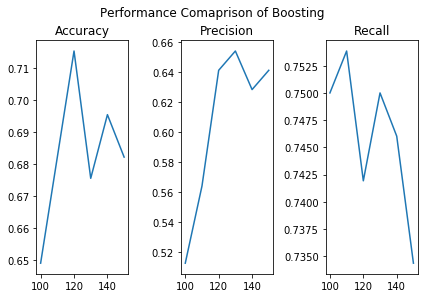

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Performance Comaprison of Boosting', va='bottom')
ax1.plot(score_df['count'], score_df['accuracy'])
ax2.plot(score_df['count'], score_df['precision'])
ax3.plot(score_df['count'], score_df['recall'])
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
fig.tight_layout()

In [83]:
## Bagging
from sklearn.ensemble import BaggingClassifier

In [85]:
score_list = []
for steps in range(100, 160, 10):
    scores = {}
    scores['count'] = steps
    scores['accuracy'] = accuracy_score(BaggingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['precision'] = precision_score(BaggingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['recall'] = recall_score(BaggingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    score_list.append(scores)
score_df = pd.DataFrame(score_list)
score_df

,count,accuracy,precision,recall
0,100,0.735099,0.743590,0.726190
1,110,0.754967,0.833333,0.786667
2,120,0.761589,0.807692,0.759494
3,130,0.761589,0.794872,0.750000
4,140,0.741722,0.807692,0.759494
5,150,0.754967,0.769231,0.772152


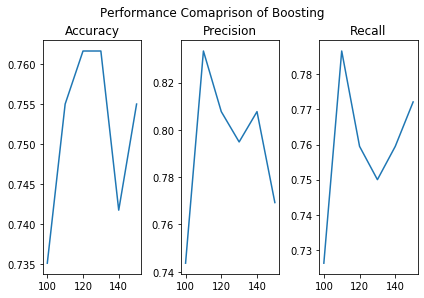

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Performance Comaprison of Boosting', va='bottom')
ax1.plot(score_df['count'], score_df['accuracy'])
ax2.plot(score_df['count'], score_df['precision'])
ax3.plot(score_df['count'], score_df['recall'])
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
fig.tight_layout()

In [87]:
score_list = []
for steps in range(100, 160, 10):
    scores = {}
    scores['count'] = steps
    scores['accuracy'] = accuracy_score(RandomForestClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['precision'] = precision_score(RandomForestClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['recall'] = recall_score(RandomForestClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    score_list.append(scores)
score_df = pd.DataFrame(score_list)

In [88]:
score_df

,count,accuracy,precision,recall
0,100,0.735099,0.782051,0.732558
1,110,0.768212,0.756410,0.746835
2,120,0.735099,0.717949,0.753086
3,130,0.761589,0.807692,0.768293
4,140,0.748344,0.794872,0.784810
5,150,0.754967,0.769231,0.743902


Text(0.5, 1.0, 'Recall')

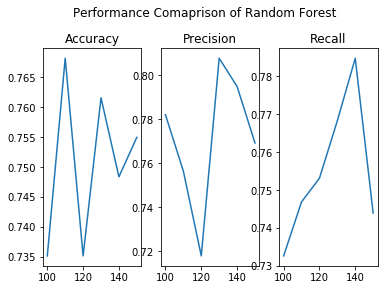

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Performance Comaprison of Random Forest', va='bottom')
ax1.plot(score_df['count'], score_df['accuracy'])
ax2.plot(score_df['count'], score_df['precision'])
ax3.plot(score_df['count'], score_df['recall'])
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
# fig.tight_layout()

In [90]:
for step in [100,110,120,130, 140, 150]:
    clf = RandomForestClassifier(n_estimators=step)
    clf.fit(X_train, y_train)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    best_10 = indices[0:10]
    print("=============For Tree Count " + str(step) + " ===================")
    for i in best_10:
        print(feature_names[i])

=============For Tree Count 100 ===================
W__coronavirus
W__china
W__peopl
W__numnum
W__virus
W__chines
W__num
W__case
W__wuhan
W__infect
=============For Tree Count 110 ===================
W__coronavirus
W__china
W__peopl
W__numnum
W__virus
W__wuhan
W__num
W__chines
W__case
W__time
=============For Tree Count 120 ===================
W__coronavirus
W__china
W__peopl
W__virus
W__num
W__chines
W__numnum
W__spread
W__time
W__wuhan
=============For Tree Count 130 ===================
W__coronavirus
W__china
W__peopl
W__virus
W__numnum
W__chines
W__num
W__wuhan
W__case
W__outbreak
=============For Tree Count 140 ===================
W__coronavirus
W__china
W__peopl
W__virus
W__numnum
W__chines
W__num
W__wuhan
W__time
W__spread
=============For Tree Count 150 ===================
W__coronavirus
W__china
W__virus
W__peopl
W__numnum
W__chines
W__wuhan
W__num
W__time
W__case
